In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import optimize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

class Parameters_SEIR_standard_testing:
    
    def __init__(self, R0, r_v, t_E, t_I, t_S, t_Q, t_linspace):
        
        self.R0 = R0
        self.r_v = r_v
        self.sigma = 1 / t_E
        self.gamma = 1 / t_I
        self.omega = 1 / t_S
        self.delta = 1 / t_Q
        self.beta = R0 * self.gamma
        self.t_linspace = t_linspace

        if r_v * t_S >= 1:
            
            print("r_v * t_S must be less than 1")
            
        else:
        
            self.r_i = r_v / (1 - r_v * t_S)
        
class SEIR_standard_testing:
    
    def __init__(self, param_obj):
        
        self.beta = param_obj.beta
        self.r_v = param_obj.r_v
        self.r_i = param_obj.r_i
        self.sigma = param_obj.sigma
        self.gamma = param_obj.gamma
        self.omega = param_obj.omega
        self.delta = param_obj.delta
        self.t_linspace = param_obj.t_linspace
        self.R0 = param_obj.R0
        
    def fun(self, t, y):
        
        S, Sneg = y[0:2]
        E, Epos, Eneg, EQ = y[2:6]
        I, Ipos, Ineg, IQ = y[6:10]
        R, Rpos, Rneg, RQ = y[10:14]
        
        
        d_S_dt = self.omega * Sneg  - self.beta * S * (I + Ipos + Ineg) - self.r_i * S
        d_Sneg_dt = self.r_i * S  - self.beta * Sneg * (I + Ipos + Ineg) - self.omega * Sneg
        d_E_dt = self.beta * S * (I + Ipos + Ineg) + self.omega * Eneg + self.delta * EQ - self.r_i * E - self.sigma * E
        d_Epos_dt = self.r_i * E - self.omega * Epos - self.sigma * Epos
        d_Eneg_dt = self.beta * Sneg * (I + Ipos + Ineg) - (self.omega + self.sigma) * Eneg
        d_EQ_dt = self.omega * Epos - self.delta * EQ - self.sigma * EQ
        d_I_dt = self.sigma * E + self.omega * Ineg + self.delta * IQ - self.r_i * I - self.gamma * I
        d_Ipos_dt = self.sigma * Epos + self.r_i * I - self.omega * Ipos - self.gamma * Ipos
        d_Ineg_dt = self.sigma * Eneg - (self.omega + self.gamma) * Ineg
        d_IQ_dt = self.sigma * EQ + self.omega * Ipos - self.delta * IQ - self.gamma * IQ
        d_R_dt = self.gamma * I  + self.omega * Rneg + self.delta * RQ - self.r_i * R
        d_Rpos_dt = self.gamma * Ipos - self.omega * Rpos
        d_Rneg_dt = self.gamma * Ineg + self.r_i * R  - self.omega * Rneg
        d_RQ_dt = self.gamma * IQ + self.omega * Rpos - self.delta * RQ
        
        dydt = [d_S_dt, d_Sneg_dt, d_E_dt, d_Epos_dt, d_Eneg_dt, d_EQ_dt, d_I_dt, d_Ipos_dt, d_Ineg_dt, d_IQ_dt, d_R_dt, d_Rpos_dt, d_Rneg_dt, d_RQ_dt]
        
        return dydt
    
    def generate_solution(self, y0 = None, method = 'LSODA'):
        
        # This generates a solution over a linear time space t_linspace
        
        if y0 == None:
            y0 = [7999999/8000000, 0, 1/8000000, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        
        t0, tf = self.t_linspace[0], self.t_linspace[-1]
        return solve_ivp(self.fun, (t0, tf), y0, method, t_eval = self.t_linspace)
    
    def S(self, compartment_string = None):
        
        if compartment_string == None:
            
            return self.sol[0]
        
        
        elif compartment_string == 'neg':
            
            return self.sol[1]
    
    def E(self, compartment_string = None):
        
        if compartment_string == None:
            
            return self.sol[2]
        
        elif compartment_string == 'pos':
            
            return self.sol[3]
        
        elif compartment_string == 'neg':
            
            return self.sol[4]        
        
        elif compartment_string == 'Q':
            
            return self.sol[5] 
        
    def I(self, compartment_string = None):
        
        if compartment_string == None:
            
            return self.sol[6]
        
        elif compartment_string == 'pos':
            
            return self.sol[7]
        
        elif compartment_string == 'neg':
            
            return self.sol[8]    
        
        elif compartment_string == 'Q':
            
            return self.sol[9]
        
    def R(self, compartment_string = None):
        
        if compartment_string == None:
            
            return self.sol[10]
        
        elif compartment_string == 'pos':
            
            return self.sol[11]
        
        elif compartment_string == 'neg':
            
            return self.sol[12]
        
        elif compartment_string == 'Q':
            
            return self.sol[13]
            
    def r_SEIR_traditional(self):
        
        return (1/2) * (- (self.sigma + self.gamma) + np.sqrt((self.sigma + self.gamma)**2 + 4 * self.sigma * (self.beta - self.gamma)))  
    
    def E_proportion_infected_population_limiting_SEIR_traditional(self):
        
        r = self.r_SEIR_traditional()
        
        return (self.gamma + r) / (self.sigma + self.gamma + r)

    def I_proportion_infected_population_limiting_SEIR_traditional(self):
        
        r = self.r_SEIR_traditional()
        
        return (self.sigma) / (self.sigma + self.gamma + r)      
    
    def prob_step(self, compartment_from, compartment_to, param_obj):
        
        if compartment_from == 'E':
            
            if compartment_to == 'Epos':
                
                return param_obj.r_i / (param_obj.r_i + param_obj.sigma)
            
            elif compartment_to == 'I':
                
                return param_obj.sigma / (param_obj.r_i + param_obj.sigma)
            
            else:
                
                return 0
            
        elif compartment_from == 'Epos':
            
            if compartment_to == 'EQ':
                
                return param_obj.omega / (param_obj.omega + param_obj.sigma)
            
            elif compartment_to == 'Ipos':
                
                return param_obj.sigma / (param_obj.omega + param_obj.sigma)
            
            else:
                
                return 0
            
        elif compartment_from == 'Eneg':
            
            if compartment_to == 'E':
                
                return param_obj.omega / (param_obj.omega + param_obj.sigma)
            
            elif compartment_to == 'Ineg':
                
                return param_obj.sigma / (param_obj.omega + param_obj.sigma)
            
            else:
                
                return 0
            
        elif compartment_from == 'EQ':
            
            if compartment_to == 'E':
                
                return param_obj.delta / (param_obj.delta + param_obj.sigma)
            
            elif compartment_to == 'IQ':
                
                return param_obj.sigma / (param_obj.delta + param_obj.sigma)
            
            else:
                
                return 0
            
        elif compartment_from == 'I':
            
            if compartment_to == 'Ipos':
                
                return param_obj.r_i / (param_obj.r_i + param_obj.gamma)
            
            elif compartment_to == 'R':
                
                return param_obj.gamma / (param_obj.r_i + param_obj.gamma)
            
            else:
                
                return 0
            
        elif compartment_from == 'Ipos':
            
            if compartment_to == 'IQ':
                
                return param_obj.omega / (param_obj.omega + param_obj.gamma)
            
            elif compartment_to == 'Rpos':
                
                return param_obj.gamma / (param_obj.omega + param_obj.gamma)
            
            else:
                
                return 0
            
        elif compartment_from == 'Ineg':
            
            if compartment_to == 'I':
                
                return param_obj.omega / (param_obj.omega + param_obj.gamma)
            
            elif compartment_to == 'Rneg':
                
                return param_obj.gamma / (param_obj.omega + param_obj.gamma)
            
            else:
                
                return 0
        
        elif compartment_from == 'IQ':
            
            if compartment_to == 'I':
                
                return param_obj.delta / (param_obj.delta + param_obj.gamma)
            
            elif compartment_to == 'RQ':
                
                return param_obj.gamma / (param_obj.delta + param_obj.gamma)
            
            else:
                
                return 0
            
    def prob_chain(self, compartments, param_obj):
        
        chain_probability = 1
        
        for i in range(len(compartments) - 1):
            
            compartment_from = compartments[i]
            compartment_to = compartments[i + 1]
            
            chain_probability = chain_probability * self.prob_step(compartment_from, compartment_to, param_obj)
            
        return chain_probability
          
    def prob_return(self, compartment, param_obj):
        
        if compartment == "E":
            
            return self.prob_chain(['E', 'Epos', 'EQ', 'E'], param_obj)
        
        elif compartment == 'Epos':
            
            return self.prob_chain(['Epos', 'EQ', 'E', 'Epos'], param_obj)
        
        elif compartment == 'Eneg':
            
            return 0
        
        elif compartment == 'EQ':
            
            return self.prob_chain(['EQ', 'E', 'Epos', 'EQ'], param_obj)
        
        elif compartment == 'I':
            
            return self.prob_chain(['I', 'Ipos', 'IQ', 'I'], param_obj)
        
        elif compartment == 'Ipos':
            
            return self.prob_chain(['Ipos', 'IQ', 'I', 'Ipos'], param_obj)
        
        elif compartment == 'Ineg':
            
            return 0
        
        elif compartment == 'IQ':
            
            return self.prob_chain(['IQ', 'I', 'Ipos', 'IQ'], param_obj)    
        
    def prob_advance(self, compartment, param_obj):
        
        if compartment == "E":
            
            return self.prob_step('E', 'I', param_obj) * 1 / (1 - self.prob_return("E", param_obj))
        
        elif compartment == "Epos":
            
            return self.prob_step('Epos', 'Ipos', param_obj) * 1 / (1 - self.prob_return("Epos", param_obj))
        
        elif compartment == "Eneg":
            
            return self.prob_step('Eneg', 'Ineg', param_obj) * 1 / (1 - self.prob_return("Eneg", param_obj))
        
        elif compartment == "EQ":
            
            return self.prob_step('EQ', 'IQ', param_obj) * 1 / (1 - self.prob_return("EQ", param_obj))
        
        elif compartment == "I":
            
            return self.prob_step('I', 'R', param_obj) * 1 / (1 - self.prob_return("I", param_obj))
        
        elif compartment == "Ipos":
            
            return self.prob_step('Ipos', 'Rpos', param_obj) * 1 / (1 - self.prob_return("Ipos", param_obj))
        
        elif compartment == "Ineg":
            
            return self.prob_step('Ineg', 'Rneg', param_obj) * 1 / (1 - self.prob_return("Ineg", param_obj))
        
        elif compartment == "IQ":
            
            return self.prob_step('IQ', 'RQ', param_obj) * 1 / (1 - self.prob_return("IQ", param_obj))
        
    def expected_sojourn_time(self, compartment, param_obj):
        
        if compartment == 'I':
            
            return 1 / (param_obj.r_i + param_obj.gamma) * 1 / (1 - self.prob_return("I", param_obj))
        
        elif compartment == 'Ipos':
            
            return 1 / (param_obj.omega + param_obj.gamma) * 1 / (1 - self.prob_return("Ipos", param_obj))
        
        elif compartment == 'Ineg':
            
            return 1 / (param_obj.omega + param_obj.gamma) * 1 / (1 - self.prob_return("Ineg", param_obj))
        
    def prob_infected_in(self, compartment, param_obj):
        
        if compartment == 'S':
            
            return param_obj.omega / (param_obj.omega + param_obj.r_i)
        
        elif compartment == 'Sneg':
            
            return param_obj.r_i / (param_obj.omega + param_obj.r_i)
        
        else:
            
            return None
        
    def prob_hit(self, compartment_from, compartment_to, param_obj):
        
        if compartment_from == "E":
            
            if compartment_to == 'I':
                
                return self.prob_advance("E", param_obj) + self.prob_step('E', 'Epos', param_obj) * self.prob_advance("Epos", param_obj) * self.prob_chain(["Ipos", "IQ", "I"], param_obj) + self.prob_chain(["E", "Epos", "EQ"], param_obj) * self.prob_advance("EQ", param_obj) * self.prob_step('IQ', "I", param_obj)
            
            elif compartment_to == 'Ipos':
                
                return self.prob_advance("E", param_obj) * self.prob_step('I', "Ipos", param_obj) + self.prob_step('E', "Epos", param_obj) * self.prob_advance("Epos", param_obj) + self.prob_chain(["E", "Epos", "EQ"], param_obj) * self.prob_advance("EQ", param_obj) * self.prob_chain(["IQ", "I", "Ipos"], param_obj) 
        
        elif compartment_from == 'Eneg':
            
            if compartment_to == 'I':
                
                return self.prob_advance("Eneg", param_obj) * self.prob_step('Ineg', "I", param_obj) + self.prob_step('Eneg', "E", param_obj) * self.prob_advance("E", param_obj) + self.prob_chain(["Eneg", "E", "Epos"], param_obj)* self.prob_advance("Epos", param_obj) * self.prob_chain(["Ipos", "IQ", "I"], param_obj) + self.prob_chain(["Eneg", "E", "Epos", "EQ"], param_obj) * self.prob_advance("EQ", param_obj) * self.prob_step('IQ', 'I', param_obj)
            
            elif compartment_to == 'Ipos':
                
                return self.prob_advance("Eneg", param_obj) * self.prob_chain(["Ineg", "I", "Ipos"], param_obj) + self.prob_step('Eneg', 'E', param_obj) * self.prob_advance("E", param_obj) * self.prob_step('I', "Ipos", param_obj) + self.prob_chain(["Eneg", "E", "Epos"], param_obj) * self.prob_advance("Epos", param_obj) + self.prob_chain(["Eneg", "E", "Epos", "EQ"], param_obj) * self.prob_advance("EQ", param_obj) * self.prob_chain(["IQ", "I", "Ipos"], param_obj)
            
            elif compartment_to == 'Ineg':
                
                return self.prob_step('Eneg', 'Ineg', param_obj)
            
    def generate_R0_s(self, param_obj):
        
        # E_X_Y is expected time spent in X given an individual was infected in Y
        
        E_I_S = self.prob_infected_in('S', param_obj) * self.prob_hit('E', 'I', param_obj) * self.expected_sojourn_time('I', param_obj)
        E_Ipos_S = self.prob_infected_in('S', param_obj) * self.prob_hit('E', 'Ipos', param_obj) * self.expected_sojourn_time('Ipos', param_obj)
        E_I_Sneg = self.prob_infected_in('Sneg', param_obj) * self.prob_hit('Eneg', 'I', param_obj) * self.expected_sojourn_time('I',  param_obj)
        E_Ipos_Sneg = self.prob_infected_in('Sneg', param_obj) * self.prob_hit('Eneg', 'Ipos', param_obj) * self.expected_sojourn_time('Ipos', param_obj)
        E_Ineg_Sneg = self.prob_infected_in('Sneg', param_obj) * self.prob_hit('Eneg', 'Ineg', param_obj) * self.expected_sojourn_time('Ineg', param_obj)
        
        return param_obj.beta * (E_I_S + E_Ipos_S + E_I_Sneg + E_Ipos_Sneg + E_Ineg_Sneg)
    
    def code_checks(self, param_obj):
        
        # There are checks to see that the probabilities I've coded above satisfy certain conditions that
        # should be true mathematically
        
        #1. A person can either be in S or Sneg when infected
        
        if self.prob_infected_in('S', param_obj) + self.prob_infected_in('Sneg', param_obj) != 1:
            
            print ("The probability of being infected in S added to the probability of being infected in Sneg doesn't add to 1")
            return 0
        
        #2. The probability of not returning to a compartment in the latent or infectious phase equals the probability
        # that you recovered before you returned
        
        
        prob_dont_return_to_E_1 = 1 - self.prob_return('E', param_obj)
        prob_dont_return_to_E_2 = self.prob_step('E', 'I', param_obj) + self.prob_chain(['E', 'Epos', 'Ipos'], param_obj) + self.prob_chain(['E', 'Epos', 'EQ', 'IQ'], param_obj)

        prob_dont_return_to_Epos_1 = 1 - self.prob_return('Epos', param_obj) 
        prob_dont_return_to_Epos_2 = self.prob_step('Epos', 'Ipos', param_obj) + self.prob_chain(['Epos', 'EQ', 'IQ'], param_obj) + self.prob_chain(['Epos', 'EQ', 'E', 'I'], param_obj)
        
        prob_dont_return_to_EQ_1 = 1 - self.prob_return('EQ', param_obj) 
        prob_dont_return_to_EQ_2 = self.prob_step('EQ', 'IQ', param_obj) + self.prob_chain(['EQ', 'E', 'I'], param_obj) + self.prob_chain(['EQ', 'E', 'Epos', 'Ipos'], param_obj)
        
        prob_dont_return_to_I_1 =  1 - self.prob_return('I', param_obj) 
        prob_dont_return_to_I_2 = self.prob_step('I', 'R', param_obj) + self.prob_chain(['I', 'Ipos', 'Rpos'], param_obj) + self.prob_chain(['I', 'Ipos', 'IQ', 'RQ'], param_obj)
        
        prob_dont_return_to_Ipos_1 = 1 - self.prob_return('Ipos', param_obj) 
        prob_dont_return_to_Ipos_2 = self.prob_step('Ipos', 'Rpos', param_obj) + self.prob_chain(['Ipos', 'IQ', 'RQ'], param_obj) + self.prob_chain(['Ipos', 'IQ', 'I', 'R'], param_obj)
        
        prob_dont_return_to_IQ_1 = 1 - self.prob_return('IQ', param_obj) 
        prob_dont_return_to_IQ_2 = self.prob_step('IQ', 'RQ', param_obj) + self.prob_chain(['IQ', 'I', 'R'], param_obj) + self.prob_chain(['IQ', 'I', 'Ipos', 'Rpos'], param_obj)
  

        if prob_dont_return_to_E_1 != prob_dont_return_to_E_2:
            
            print('The probability of not returning to E isn\'t correct')
            print(prob_dont_return_to_E_1)
            print(prob_dont_return_to_E_2)
        
        if prob_dont_return_to_Epos_1 != prob_dont_return_to_Epos_2:
            
            print('The probability of not returning to Epos isn\'t correct')  
            print(prob_dont_return_to_Epos_1)
            print(prob_dont_return_to_Epos_2)
        
        if prob_dont_return_to_EQ_1 != prob_dont_return_to_EQ_2:
            
            print('The probability of not returning to EQ isn\'t correct')  
            print(str(1 - self.prob_return('EQ', param_obj)))
            print(str(self.prob_step('EQ', 'IQ', param_obj) + self.prob_chain(['EQ', 'E', 'I'], param_obj) + self.prob_chain(['EQ', 'E', 'Epos', 'Ipos'], param_obj)))
            
        if prob_dont_return_to_I_1 != prob_dont_return_to_I_2:
            
            print('The probability of not returning to I isn\'t correct')
            print(str(1 - self.prob_return('I', param_obj)))
            print(str(self.prob_step('I', 'R', param_obj) + self.prob_chain(['I', 'Ipos', 'Rpos'], param_obj) + self.prob_chain(['I', 'Ipos', 'IQ', 'RQ'], param_obj)))
        
        if prob_dont_return_to_Ipos_1 != prob_dont_return_to_Ipos_2:
            
            print('The probability of not returning to Ipos isn\'t correct') 
            print(str(1 - self.prob_return('Ipos', param_obj)))
            print(str( self.prob_step('Ipos', 'Rpos', param_obj) + self.prob_chain(['Ipos', 'IQ', 'RQ'], param_obj) + self.prob_chain(['Ipos', 'IQ', 'I', 'R'], param_obj)))
        
        if prob_dont_return_to_IQ_1 != prob_dont_return_to_IQ_2:
            
            print('The probability of not returning to IQ isn\'t correct') 
            print(str(1 - self.prob_return('IQ', param_obj)))
            print(str(self.prob_step('IQ', 'RQ', param_obj) + self.prob_chain(['IQ', 'I', 'R'], param_obj) + self.prob_chain(['IQ', 'I', 'Ipos', 'Rpos'], param_obj)))
            
        #3. Check the probabilities of return all equal
        
        if self.prob_return('E', param_obj) == self.prob_return('Epos', param_obj) == self.prob_return('EQ', param_obj) == False:
            
            print('Probabilities of return don\'t equal for latent compartments')
            
        if self.prob_return('I', param_obj) == self.prob_return('Ipos', param_obj) == self.prob_return('IQ', param_obj) == False:
            
            print('Probabilities of return don\'t equal for infectious compartments')    
            
        #4. Check all the step probabilities add to one
        
        compartment_from_list = ['E', 'Epos', 'Eneg', 'EQ', 'I', 'Ipos', 'Ineg', 'IQ']
        compartment_to_list = ['E', 'Epos', 'Eneg', 'EQ', 'I', 'Ipos', 'Ineg', 'IQ', 'R', 'Rpos', 'Rneg', 'RQ']  
        
        for compartment_from in compartment_from_list:
            
            summed_probability = 0
            
            for compartment_to in compartment_to_list:
                
                summed_probability += self.prob_step(compartment_from, compartment_to, param_obj)
                
            if summed_probability != 1:
                
                print(compartment_from + ' has an issue with it\'s step probabilty')
                
        #5. Check that the advancement probabilities add to 1
        
        prob_advance_all_paths_E = self.prob_advance('E', param_obj) + self.prob_step('E', 'Epos', param_obj) * self.prob_advance('Epos', param_obj) + self.prob_chain(['E', 'Epos', 'EQ'], param_obj) * self.prob_advance('EQ', param_obj)
        prob_advance_all_paths_Epos = self.prob_advance('Epos', param_obj) + self.prob_step('Epos', 'EQ', param_obj) * self.prob_advance('EQ', param_obj) + self.prob_chain(['Epos', 'EQ', 'E'], param_obj) * self.prob_advance('E', param_obj)
        prob_advance_all_paths_Eneg = self.prob_advance('Eneg', param_obj) + self.prob_step('Eneg', 'E', param_obj) * self.prob_advance('E', param_obj) + self.prob_chain(['Eneg', 'E', 'Epos'], param_obj) * self.prob_advance('Epos', param_obj) + self.prob_chain(['Eneg', 'E', 'Epos', 'EQ'], param_obj) * self.prob_advance('EQ', param_obj)
        prob_advance_all_paths_EQ = self.prob_advance('EQ', param_obj) + self.prob_step('EQ', 'E', param_obj) * self.prob_advance('E', param_obj) + self.prob_chain(['EQ', 'E', 'Epos'], param_obj) * self.prob_advance('Epos', param_obj)
        
        prob_advance_all_paths_I = self.prob_advance('I', param_obj) + self.prob_step('I', 'Ipos', param_obj) * self.prob_advance('Ipos', param_obj) + self.prob_chain(['I', 'Ipos', 'IQ'], param_obj) * self.prob_advance('IQ', param_obj)
        prob_advance_all_paths_Ipos = self.prob_advance('Ipos', param_obj) + self.prob_step('Ipos', 'IQ', param_obj) * self.prob_advance('IQ', param_obj) + self.prob_chain(['Ipos', 'IQ', 'I'], param_obj) * self.prob_advance('I', param_obj)
        prob_advance_all_paths_Ineg = self.prob_advance('Ineg', param_obj) + self.prob_step('Ineg', 'I', param_obj) * self.prob_advance('I', param_obj) + self.prob_chain(['Ineg', 'I', 'Ipos'], param_obj) * self.prob_advance('Ipos', param_obj) + self.prob_chain(['Ineg', 'I', 'Ipos', 'IQ'], param_obj) * self.prob_advance('IQ', param_obj)
        prob_advance_all_paths_IQ = self.prob_advance('IQ', param_obj) + self.prob_step('IQ', 'I', param_obj) * self.prob_advance('I', param_obj) + self.prob_chain(['IQ', 'I', 'Ipos'], param_obj) * self.prob_advance('Ipos', param_obj)
       
        if prob_advance_all_paths_E != 1:
            
            print('The advancement probabilities from the point of view of an individual in E don\'t sum to 1')
            print(str(prob_advance_all_paths_E))
            
        if prob_advance_all_paths_Epos != 1:
            
            print('The advancement probabilities from the point of view of an individual in Epos don\'t sum to 1')
            print(str(prob_advance_all_paths_Epos))     
            
        if prob_advance_all_paths_Eneg != 1:
            
            print('The advancement probabilities from the point of view of an individual in Eneg don\'t sum to 1')
            print(str(prob_advance_all_paths_Eneg))
            
        if prob_advance_all_paths_EQ != 1:
            
            print('The advancement probabilities from the point of view of an individual in EQ don\'t sum to 1')
            print(str(prob_advance_all_paths_EQ))  
            
        if prob_advance_all_paths_I != 1:
            
            print('The advancement probabilities from the point of view of an individual in I don\'t sum to 1')
            print(str(prob_advance_all_paths_I))
            
        if prob_advance_all_paths_Ipos != 1:
            
            print('The advancement probabilities from the point of view of an individual in Ipos don\'t sum to 1')
            print(str(prob_advance_all_paths_Ipos))     
            
        if prob_advance_all_paths_Ineg != 1:
            
            print('The advancement probabilities from the point of view of an individual in Ineg don\'t sum to 1')
            print(str(prob_advance_all_paths_Ineg))
            
        if prob_advance_all_paths_IQ != 1:
            
            print('The advancement probabilities from the point of view of an individual in IQ don\'t sum to 1')
            print(str(prob_advance_all_paths_IQ))               
    
    def final_size(self):
        
        f = lambda x: 1 - x - np.exp(-self.R0 * x)
        
        return optimize.newton(f, 0.99)
    
    def final_size_numerical(self):
        
        # Returns the final size of the epidemic as calculated using the numerical solution. 
        # Made as a check to see the analytic form in final_size is correct
        
        return 1 - (self.S()[-1] + self.S("neg")[-1])
    
    def parameter_that_returns_final_size(self, parameter_string, final_size_proportion, visual_check = False):
        
        # Returns the parameter value needed such that you get that final_size_proportion
        
        if parameter_string == "r_i":
            
            # Means we are looking for parameter values of r_i that will return a 
            # final size proportion equal to final_size_proportion
            
            f = lambda r_i: 1 - final_size_proportion - np.exp(-self.generate_R0(self.beta, r_i, self.omega, self.delta, self.sigma, self.gamma) * final_size_proportion)

            optimal_r_i = optimize.newton(f, 0.1)
            
            if visual_check == True:

                r_i_vals = np.linspace(0.01, 1, 1000)
                plt.plot(r_i_vals, [f(r_i) for r_i in r_i_vals])
                plt.scatter(optimal_r_i, f(optimal_r_i))
                plt.show()
                                                               
            return optimal_r_i
        
        elif parameter_string == "t_S":
            
            # Looking for values of the turnaround time for tests t_S that will return a final size proportion
            # equal to final_size_proportion
            
            f = lambda t_S: 1 - final_size_proportion - np.exp(-self.generate_R0(self.beta, self.r_i, 1 / t_S, self.delta, self.sigma, self.gamma) * final_size_proportion)
            
            
            try:
                optimal_t_S = optimize.newton(f, 0.1)
                
            except Exception as e:
                
                # Handle a runtime error here like failure to converge
                
                print(f"An error occurred: {e}")
                t_S_vals = np.linspace(0.01, 20, 1000)
                plt.plot(t_S_vals, f(t_S_vals))
                plt.show()
            
            except:
                
                if visual_check == True:
                
                    t_S_vals = np.linspace(0.01, optimal_t_S + 5, 1000)
                    plt.plot(t_S_vals, f(t_S_vals))
                    plt.scatter(optimal_t_S, f(optimal_t_S))
                    plt.show()
                    
                    return optimal_t_S
                
                else:   
                
                    return optimal_t_S
                

In [10]:
R0 = 3
r_v = 0.01
t_E, t_I = 1, 10
t_S, t_Q = 1, 14
t_linspace = np.linspace(0, 100, 100 * 1000)

param_obj = Parameters_SEIR_standard_testing(R0, r_v, t_E, t_I, t_S, t_Q, t_linspace)

beta = R0 / t_I
sigma, gamma = 1 / t_E, 1 / t_I
omega, delta = 1 / t_S, 1 / t_Q

SEIR_0 = SEIR_standard_testing(param_obj)
SEIR_0.generate_R0_s(param_obj)

2.8336902782354625

In [7]:
# Interactive plot of the components of R0

R0 = 3
def interactive_plot_R0_componants(t_S, t_Q, t_tot, latent_time_ratio):
    
    t_E, t_I = latent_time_ratio * t_tot, (1 - latent_time_ratio) * t_tot
    omega, Omega = 1 / t_S, 1 / t_Q

    t_linspace = np.linspace(0, 100, 100 * 1000)
    
    r_v_max = 1 / t_S - 0.01
    r_v_values = np.linspace(0, r_v_max, 1000)
    
    param_objs = [Parameters_SEIR_standard_testing(R0, r_v, t_E, t_I, t_S, t_Q, t_linspace) for r_v in r_v_values]
    
    standard_R0_values = [SEIR_0.generate_R0_s(param_obj)[0] for param_obj in param_objs]
    
    E_I_S_values = [beta * SEIR_0.generate_R0_s(param_obj)[1] for param_obj in param_objs]
    E_Ipos_S_values = [beta * SEIR_0.generate_R0_s(param_obj)[2] for param_obj in param_objs]
    E_I_Sneg_values = [beta * SEIR_0.generate_R0_s(param_obj)[3]  for param_obj in param_objs]
    E_Ipos_Sneg_values = [beta * SEIR_0.generate_R0_s(param_obj)[4] for param_obj in param_objs]
    E_Ineg_Sneg_values = [beta * SEIR_0.generate_R0_s(param_obj)[5] for param_obj in param_objs]
    
    fig, axes = plt.subplots(1, 2)
    
    axes[0].plot(r_v_values, standard_R0_values, label = r'$R_0^i$')
    axes[0].set_ylim((-0.1 , R0 + 1))
    axes[0].set_title("R0")
    axes[0].set_xlabel(r"$r_v$")
    axes[0].set_xlim(0.0, r_v_max)
    axes[0].legend()
    
    axes[1].plot(r_v_values, E_I_S_values, label = "I_S")
    axes[1].plot(r_v_values, E_Ipos_S_values, label = "Ipos_S")
    axes[1].plot(r_v_values, E_I_Sneg_values, label = "I_Sneg")
    axes[1].plot(r_v_values, E_Ipos_Sneg_values, label = "Ipos_Sneg")
    axes[1].plot(r_v_values, E_Ineg_Sneg_values, label = "Ineg_Sneg")
    axes[1].set_ylim((-0.1, R0 + 1))
    axes[1].set_title("R0 components")
    axes[1].set_xlabel(r"$r_v$")
    axes[1].set_xlim(0, r_v_max)
    axes[1].legend()
    
    plt.show()
    
interact(interactive_plot_R0_componants, t_S = (1/2, 10, 1/2), t_Q = (1, 12, 1), t_tot = (1, 12, 1), latent_time_ratio = (0.1, 0.9, 0.1))

interactive(children=(FloatSlider(value=5.0, description='t_S', max=10.0, min=0.5, step=0.5), IntSlider(value=…

<function __main__.interactive_plot_R0_componants(t_S, t_Q, t_tot, latent_time_ratio)>

In [6]:
# Interactive plot of total infectivity of individuals in E that will stem from their time spent in I

R0 = 3
N = 8000000

def interactive_plot_expected_time_in_I_infected_in_S(t_S, t_Q, t_tot, latent_time_ratio):
    
    t_E, t_I = latent_time_ratio * t_tot, (1 - latent_time_ratio) * t_tot

    t_linspace = np.linspace(0, 100, 100 * 1000)
    
    r_v_max = 2
    r_v_values = np.linspace(0, r_v_max, 1000)
    r_i_values = [r_v * omega / (omega - r_v) if r_v < omega else None for r_v in r_v_values]
    param_objs = [Parameters_SEIR_standard_testing(R0, N, r_i, t_E, t_I, t_S, t_Q, t_linspace) if r_i != None else None for r_i in r_i_values]
    
    
    # total_infectivity_E_I returns the infectivity caused by an individual currently in E from
    # their time spent in I
    total_infectivity_E_I = [beta * N * SEIR_0.generate_R0(param_obj)[1] if param_obj != None else None for param_obj in param_objs]
    
    prob_infected_in_S_values = [SEIR_0.prob_infected_in('S', param_obj) if param_obj != None else None for param_obj in param_objs]
    prob_hit_E_infected_in_I_values = [SEIR_0.prob_hit('E', 'I', param_obj) if param_obj != None else None for param_obj in param_objs]
    total_infectivity_I_I = [beta * N * SEIR_0.expected_sojourn_time('I', param_obj) if param_obj != None else None for param_obj in param_objs]
    
    single_pass_I_time = [1 / (r_i + gamma) if r_i != None else None for r_i in r_i_values]
    expected_visits_I_person_in_I = [1 / (1 - SEIR_0.prob_return("I", param_obj)) if param_obj != None else None for param_obj in param_objs] 
    
    prob_return_I_values = [SEIR_0.prob_return('I', param_obj) if param_obj != None else None for param_obj in param_objs]
    
    fig, axes = plt.subplots(1,4)
    
    axes[0].plot(r_v_values, total_infectivity_E_I, label = "t_i_E_I")
    axes[0].set_ylim((-0.1 , R0 + 5))
    axes[0].set_title("t_i_E_I")
    axes[0].set_xlabel(r"$r_v$")
    axes[0].set_xlim(0.0, r_v_max)
    

    axes[1].plot(r_v_values, prob_infected_in_S_values, label = r"$q_S$")
    axes[1].plot(r_v_values, prob_hit_E_infected_in_I_values, label = r"$p^H_{E,I}$")
    axes[1].plot(r_v_values, total_infectivity_I_I, label = "t_i_I_I")
    axes[1].set_ylim((-0.1, R0 + 5))
    axes[1].set_title("t_i_E_I parts")
    axes[1].set_xlabel(r"$r_v$")
    axes[1].set_xlim(0, r_v_max)
    axes[1].legend()
    
    axes[2].plot(r_v_values, single_pass_I_time, label = r"$T_I$")
    axes[2].plot(r_v_values, expected_visits_I_person_in_I, label = r"$\frac{1}{1 - P_I^R}$")
    axes[2].set_ylim((-0.1, R0 + 5))
    axes[2].set_xlim(0, r_v_max)
    axes[2].set_title("t_i_I_I parts")
    axes[2].legend()
    
    axes[3].plot(r_v_values, prob_return_I_values)
    axes[3].set_title("P return I")
    axes[3].set_ylim((0, 1))
    
    plt.tight_layout()
    
    plt.show()
    
interact(interactive_plot_expected_time_in_I_infected_in_S, t_S = (1/2, 10, 1/2), t_Q = (1, 12, 1), t_tot = (1, 12, 1), latent_time_ratio = (0.1, 0.9, 0.1))

interactive(children=(FloatSlider(value=5.0, description='t_S', max=10.0, min=0.5, step=0.5), IntSlider(value=…

<function __main__.interactive_plot_expected_time_in_I_infected_in_S(t_S, t_Q, t_tot, latent_time_ratio)>

In [18]:
# Interactive plot of the individual R0 vs the pool R0 where number of people tested per unit time is equated

R0 = 3
N = 8000000

def interactive_plot_pool_individual_R0(t_i, t_Q, t_tot, latent_time_ratio):
    
    omega = 1 / t_i
    sigma = 1 / (t_tot * latent_time_ratio)
    gamma = 1 / (t_tot * (1 - latent_time_ratio))
    beta = R0 / (N * (1 - latent_time_ratio) * t_tot)
    delta = 1 / t_Q
    
    
    r_v_max = 2
    r_v_values = np.linspace(0, r_v_max, 1000)
    r_i_values = [r_v * omega / (omega - r_v) if r_v < omega else None for r_v in r_v_values]
    
    individual_R0_values = [SEIR_0.generate_R0(beta, N, r_i, omega, delta, sigma, gamma)[0] if r_i != None else None for r_i in r_i_values]
    
    fig, axes = plt.subplots(1)
    
    axes.plot(r_v_values, individual_R0_values, label = r'$R_0^i$')
    axes.set_ylim((1, R0+10))
    axes.set_title("Individual R0 with people tested per unit time constant in vigilance stage")
    axes.set_xlabel("Proportion of population tested per unit time")
    axes.set_xlim(0, r_v_max)
    axes.legend()
    
    plt.show()
    
interact(interactive_plot_pool_individual_R0, t_P = (1/2, 10, 1/2), t_i = (1/2, 10, 1/2), t_Q = (1, 12, 1), t_tot = (1, 12, 1), latent_time_ratio = (0.1, 0.9, 0.1))

interactive(children=(FloatSlider(value=5.0, description='t_i', max=10.0, min=0.5, step=0.5), IntSlider(value=…

<function __main__.interactive_plot_pool_individual_R0(t_i, t_Q, t_tot, latent_time_ratio)>

An error occurred: Tolerance of 4.239104753396254e+28 reached. Failed to converge after 7 iterations, value is 4.2391047533902105e+28.


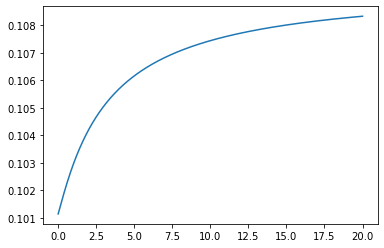

In [3]:
final_size_proportion = 0.8
SEIR_0.parameter_that_returns_final_size("t_S", final_size_proportion, visual_check = True)

In [4]:

test_compartments = ["E", "Epos", "EQ"]
print(SEIR_0.prob_chain(test_compartments, r_p, omega, delta, sigma, gamma) == SEIR_0.prob_chain_old(test_compartments))
print(SEIR_0.prob_return("E", r_p, omega, delta, sigma, gamma) == SEIR_0.prob_return_old("E"))
print(SEIR_0.generate_R0(r_p, omega, delta, sigma, gamma) == SEIR_0.generate_R0_old())


NameError: name 'r_p' is not defined

In [11]:
SEIR_0.prob_chain_old(test_compartments)

AttributeError: 'SEIR_individual_testing' object has no attribute 'prob_chain_old'

In [13]:
SEIR_0.final_size()

0.9398836632570939

In [6]:
SEIR_0.final_size_numerical()

0.9400043318783424

(0.0, 50.0)

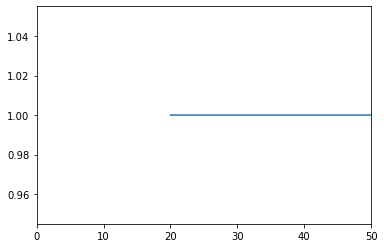

In [31]:
test_linspace = np.linspace(0, 50, 50*100)
test_solution = [1 if t > 20 else None for t in test_linspace]

plt.plot(test_linspace, test_solution)
plt.xlim(0, 50)

In [60]:
a = True == True == False

In [97]:
True != False

True

In [41]:
a

False

In [14]:
abs(-2)

2